### Estatísticas Descritivas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

#Carregando os dados
df = pd.read_excel('dados/Delivery truck trip data.xlsx', sheet_name='VTS Data 280820')

#Estatísticas descritivas
print(df.describe())

#Verificando as informações 
print(df.info())

#Verificando se há valores nulos
print(df.isnull().sum())

                      BookingID_Date                 Data_Ping_time  \
count                           6880                           5927   
mean   2020-02-08 05:18:40.453054208  2020-04-06 04:54:24.370193920   
min              2019-03-18 12:19:22            2019-06-07 18:25:10   
25%       2019-10-11 18:47:32.500000            2019-12-01 07:35:10   
50%       2020-01-20 13:49:40.500000            2020-06-19 16:10:08   
75%    2020-07-30 13:46:34.750000128            2020-08-10 15:52:45   
max              2020-12-03 13:10:21            2020-08-28 12:40:31   
std                              NaN                            NaN   

          Curr_lat     Curr_lon  TRANSPORTATION_DISTANCE_IN_KM  \
count  5927.000000  5927.000000                    6168.000000   
mean     18.679995    78.759745                     553.856282   
min       8.166790    69.657698                       0.000000   
25%      12.871868    76.891857                      40.000000   
50%      17.470922    77.84334

### Limpeza e Preparação dos Dados

In [2]:
#Tratando os valores nulos
df['ontime'] = df['ontime'].replace('NULL', np.nan)
df['delay'] = df['delay'].replace('NULL', np.nan)

#Criando uma coluna de status de pontualidade
df['on_time_status'] = np.where(df['ontime'] == 'G', 'On Time', 
                               np.where(df['delay'] == 'R', 'Delayed', 'Unknown'))

#Removendo as colunas não utilizadas
cols_to_drop = ['Minimum_kms_to_be_covered_in_a_day', 'Driver_MobileNo', 'NA']
df = df.drop(columns=cols_to_drop, errors='ignore')

#Convertendo as datas
date_cols = ['BookingID_Date', 'Data_Ping_time', 'Planned_ETA', 'actual_eta', 'trip_start_date', 'trip_end_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

### Criação de novas features

In [3]:
#Calculando a duração real da viagem
df['actual_duration'] = (df['actual_eta'] - df['trip_start_date']).dt.total_seconds() / 3600

#Calculando a duração planejada
df['planned_duration'] = (df['Planned_ETA'] - df['trip_start_date']).dt.total_seconds() / 3600

#Calculando a diferença entre real e planejado
df['duration_difference'] = df['actual_duration'] - df['planned_duration']

#Criando uma coluna de atraso
df['is_delayed'] = df['duration_difference'] > 0

#Extraindo as informações temporais
df['trip_start_hour'] = df['trip_start_date'].dt.hour
df['trip_start_day'] = df['trip_start_date'].dt.day_name()

### Análise Exploratória Detalhada

#### Distribuição de viagens por status de pontualidade

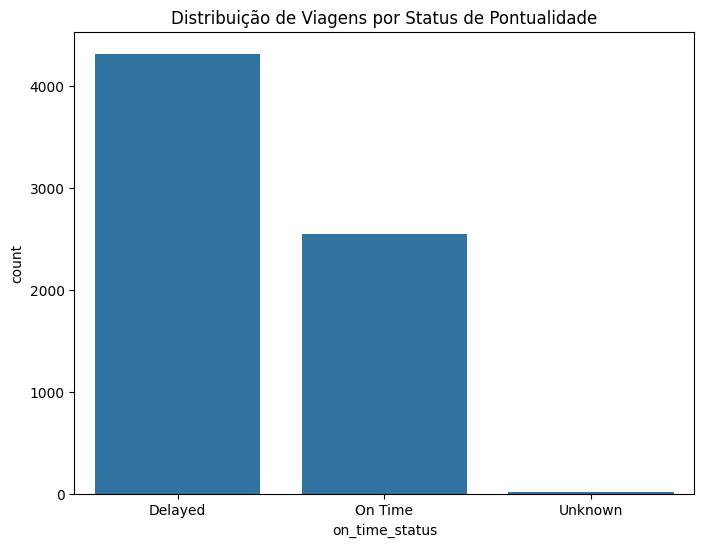

In [4]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='on_time_status')
plt.title('Distribuição de Viagens por Status de Pontualidade')
plt.show()

#### Distribuição de distâncias de transporte

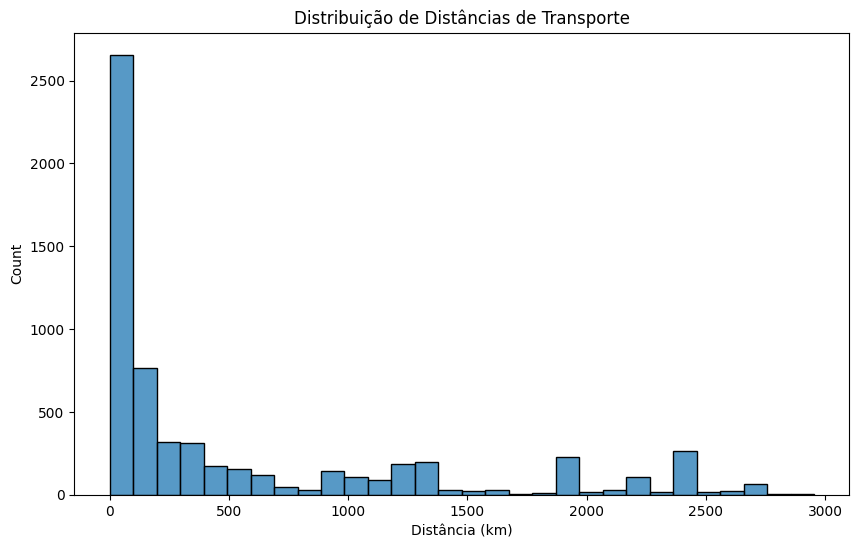

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='TRANSPORTATION_DISTANCE_IN_KM', bins=30)
plt.title('Distribuição de Distâncias de Transporte')
plt.xlabel('Distância (km)')
plt.show()

#### Correlação entre distância e duração

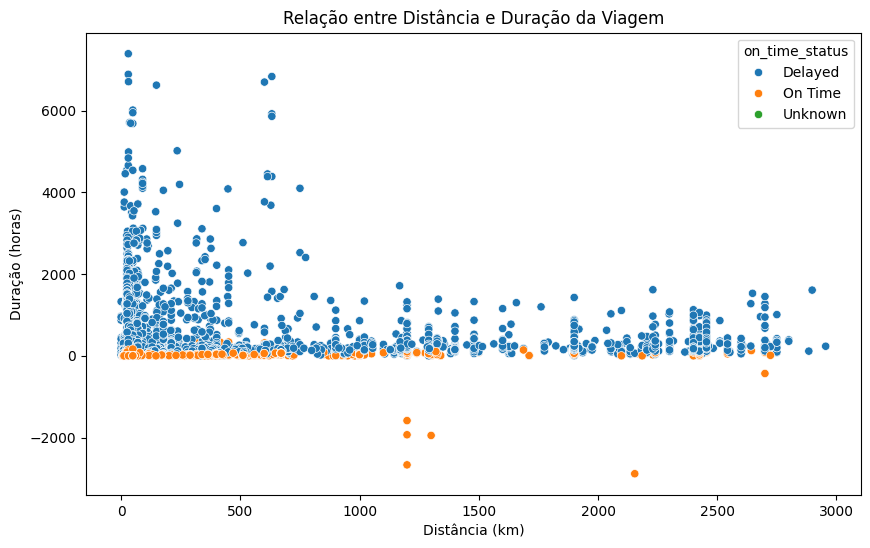

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='TRANSPORTATION_DISTANCE_IN_KM', y='actual_duration', hue='on_time_status')
plt.title('Relação entre Distância e Duração da Viagem')
plt.xlabel('Distância (km)')
plt.ylabel('Duração (horas)')
plt.show()

#### Materiais mais transportados

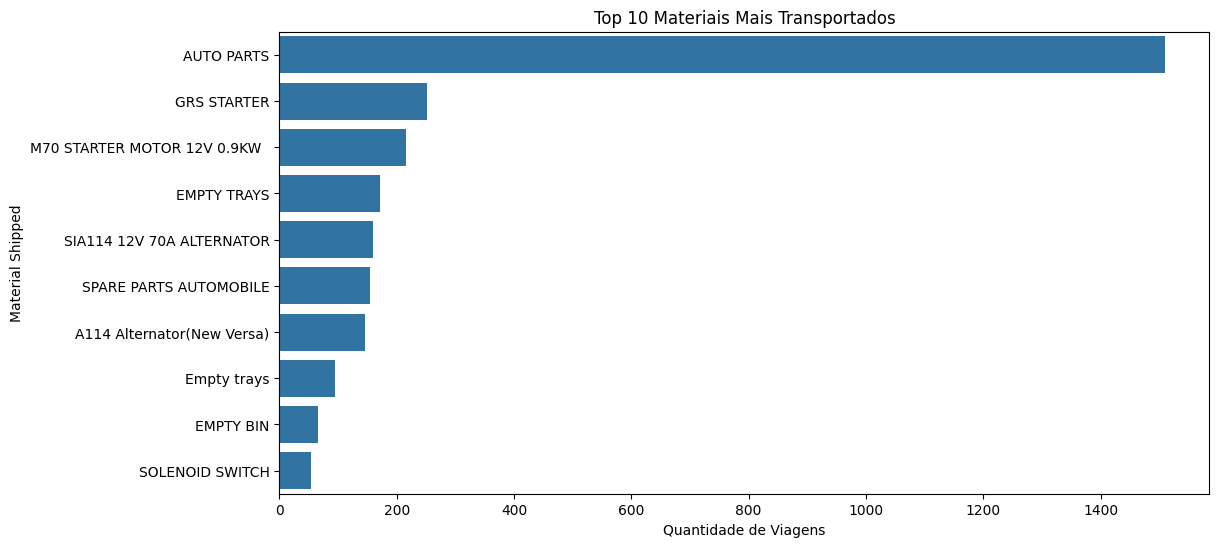

In [7]:
top_materials = df['Material Shipped'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_materials.values, y=top_materials.index)
plt.title('Top 10 Materiais Mais Transportados')
plt.xlabel('Quantidade de Viagens')
plt.show()

#### Análise temporal

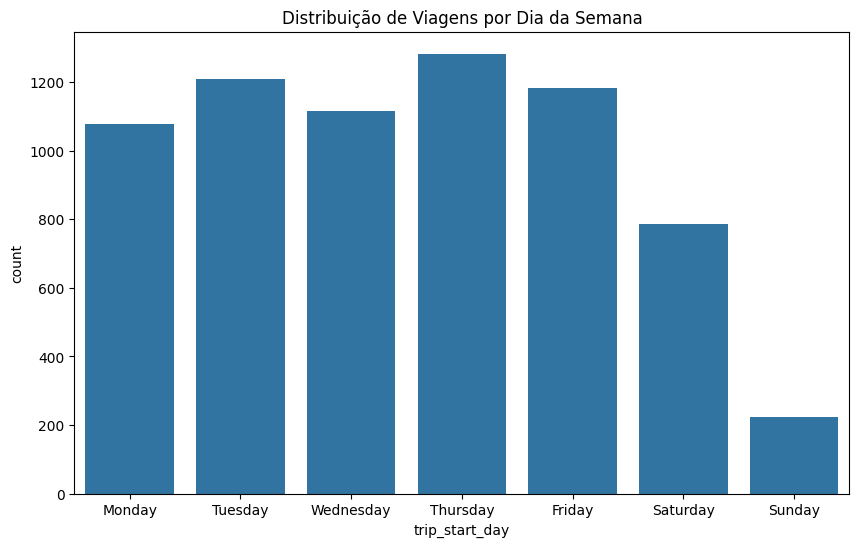

In [8]:
#Viagens por dia da semana
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='trip_start_day', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Distribuição de Viagens por Dia da Semana')
plt.show()

 

## Modelagem Preditiva (Previsão de Atrasos)

#### Pré-processamento

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Selecionando as features relevantes
features = ['TRANSPORTATION_DISTANCE_IN_KM', 'trip_start_hour', 'vehicleType']
target = 'is_delayed'

#Codificando as variáveis categóricas
le = LabelEncoder()
df['vehicleType_encoded'] = le.fit_transform(df['vehicleType'].astype(str))

#Criando um conjunto de dados para modelagem
X = df[['TRANSPORTATION_DISTANCE_IN_KM', 'trip_start_hour', 'vehicleType_encoded']]
y = df[target]

#Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Normalizando as features numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Treinamento do modelo

In [10]:
#Treinando um modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

#Fazendo as previsões
y_pred = rf.predict(X_test_scaled)

#Avaliando o modelo
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))

Acurácia: 0.8502906976744186

Relatório de Classificação:
               precision    recall  f1-score   support

       False       0.82      0.77      0.79       771
        True       0.87      0.90      0.88      1293

    accuracy                           0.85      2064
   macro avg       0.84      0.83      0.84      2064
weighted avg       0.85      0.85      0.85      2064


Matriz de Confusão:
 [[ 596  175]
 [ 134 1159]]


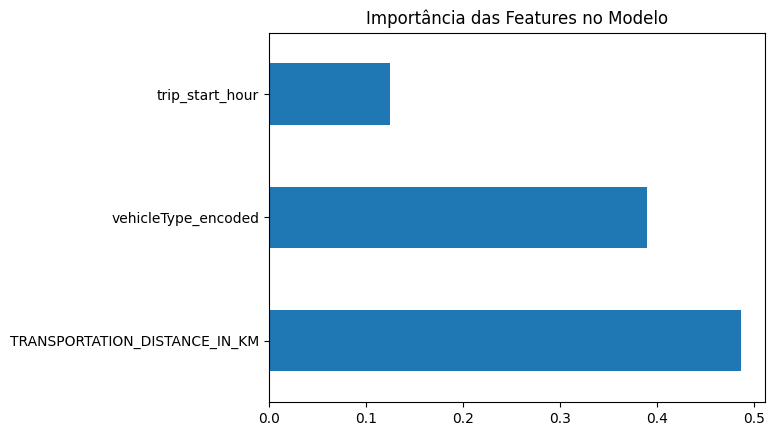

In [11]:
#Visualizando a importância das features
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Importância das Features no Modelo')
plt.show()

## Dashboard Interativo

In [12]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

#Criando o aplicativo Dash
app = dash.Dash(__name__)

#Preparando os dados para o dashboard
#Criando uma lista de opções para os dropdowns
status_options = [{'label': 'Todos', 'value': 'All'}] + [{'label': status, 'value': status} for status in df['on_time_status'].unique()]
material_options = [{'label': 'Todos', 'value': 'All'}] + [{'label': material, 'value': material} for material in df['Material Shipped'].unique()]

#Layout do dashboard
app.layout = html.Div([
    html.H1("Dashboard de Análise de Viagens de Caminhões", style={'textAlign': 'center'}),
    
    html.Div([
        html.Div([
            dcc.Dropdown(
                id='status-dropdown',
                options=status_options,
                value='All',
                multi=False,
                placeholder="Filtrar por status"
            )
        ], style={'width': '48%', 'display': 'inline-block'}),
        
        html.Div([
            dcc.Dropdown(
                id='material-dropdown',
                options=material_options,
                value='All',
                multi=False,
                placeholder="Filtrar por material"
            )
        ], style={'width': '48%', 'float': 'right', 'display': 'inline-block'})
    ]),
    
    dcc.Graph(id='distance-duration-scatter'),
    
    html.Div([
        html.Div([
            dcc.Graph(id='status-pie')
        ], style={'width': '48%', 'display': 'inline-block'}),
        
        html.Div([
            dcc.Graph(id='material-bar')
        ], style={'width': '48%', 'float': 'right', 'display': 'inline-block'})
    ]),
    
    dcc.Graph(id='time-heatmap')
])

#Callbacks 
@app.callback(
    [Output('distance-duration-scatter', 'figure'),
     Output('status-pie', 'figure'),
     Output('material-bar', 'figure'),
     Output('time-heatmap', 'figure')],
    [Input('status-dropdown', 'value'),
     Input('material-dropdown', 'value')]
)
def update_dashboard(status_filter, material_filter):
    #Criando uma cópia do dataframe para filtragem
    filtered_df = df.copy()
    
    #Aplicando os filtros
    if status_filter != 'All':
        filtered_df = filtered_df[filtered_df['on_time_status'] == status_filter]
    
    if material_filter != 'All':
        filtered_df = filtered_df[filtered_df['Material Shipped'] == material_filter]
    
    #Gráfico de dispersão
    scatter_fig = px.scatter(
        filtered_df, 
        x='TRANSPORTATION_DISTANCE_IN_KM', 
        y='actual_duration',
        color='on_time_status',
        title='Relação entre Distância e Duração da Viagem',
        labels={
            'TRANSPORTATION_DISTANCE_IN_KM': 'Distância (km)',
            'actual_duration': 'Duração Real (horas)',
            'on_time_status': 'Status'
        }
    )
    
    #Gráfico de pizza - status
    status_counts = filtered_df['on_time_status'].value_counts().reset_index()
    status_counts.columns = ['status', 'count']
    pie_fig = px.pie(
        status_counts,
        values='count',
        names='status',
        title='Distribuição de Status de Pontualidade'
    )
    
    #Gráfico de barras - materiais
    material_counts = filtered_df['Material Shipped'].value_counts().head(10).reset_index()
    material_counts.columns = ['material', 'count']
    bar_fig = px.bar(
        material_counts,
        x='count',
        y='material',
        orientation='h',
        title='Top 10 Materiais Transportados',
        labels={
            'count': 'Número de Viagens',
            'material': 'Material'
        }
    )
    
    #Heatmap temporal
    time_df = filtered_df.groupby(['trip_start_day', 'trip_start_hour']).size().reset_index(name='counts')
    #Ordenando por dias da semana
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    time_df['trip_start_day'] = pd.Categorical(time_df['trip_start_day'], categories=days_order, ordered=True)
    time_df = time_df.sort_values('trip_start_day')
    
    heat_fig = px.density_heatmap(
        time_df,
        x='trip_start_day',
        y='trip_start_hour',
        z='counts',
        title='Distribuição de Viagens por Dia e Hora',
        labels={
            'trip_start_day': 'Dia da Semana',
            'trip_start_hour': 'Hora do Dia',
            'counts': 'Número de Viagens'
        }
    )
    
    return scatter_fig, pie_fig, bar_fig, heat_fig

if __name__ == '__main__':
    app.run_server(debug=True)